# <center>Deep NN</center>
## <div align=right>Made by:</div>
**<div align=right>Jereddy Manoj</div>**
**<div align=right>Ihor Markevych</div>**
**<div align=right>Jing Liu</div>**

## Scenario
A financial institution desires to refine its targeting strategy and grow the
client population leveraging third party credit data.


--------------------------

In [1]:
import pandas as pd
import numpy as np
import pickle

import tensorflow as tf

import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import joblib

import matplotlib.pyplot as plt

# from imblearn.over_sampling import SMOTE

np.random.seed(123)

Using TensorFlow backend.


## Preprocessing

In [2]:
def preprocessing(X, scaler_filename='scaler.save', columns_to_use_filename='columns_to_use'):
    
    scaler = joblib.load(scaler_filename)
    
    with open (columns_to_use_filename, 'rb') as fp:
        columns_to_use = pickle.load(fp)    
    
    X = X.loc[:, columns_to_use]
    
    numerical_X = X.loc[:, X.dtypes != 'object']
    numerical_X = pd.DataFrame(scaler.transform(numerical_X), columns=numerical_X.columns)
    numerical_X = numerical_X.fillna(0)
    return numerical_X 
#     categorical_X = X.loc[:, X.dtypes == 'object']
#     categorical_X_encoded = pd.get_dummies(categorical_X, dummy_na=True, prefix=categorical_X.columns)
#     final_X = pd.concat([numerical_X, categorical_X_encoded], axis=1)
    
#     return final_X

In [3]:
data = pd.read_csv('/kaggle/input/Data.csv')
X = data.drop(columns='Flag')
y = data.Flag

columns_to_use = list(X.columns[(X.isna().sum() / len(X)) < 0.4])
X = X.loc[:, columns_to_use]
corrs = X.corrwith(y).abs().sort_values(ascending=False)
# columns_to_use = [x for x in columns_to_use if x not in corrs[corrs < 0.01].index.tolist()]
columns_to_use = corrs[corrs > 0.01].index.tolist()
X = X.loc[:, columns_to_use]

with open('columns_to_use', 'wb') as fp:
    pickle.dump(columns_to_use, fp)

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X.loc[:, X.dtypes != 'object'])
joblib.dump(scaler, "scaler.save") 

X_preprocessed = preprocessing(X)

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, stratify=y, test_size=0.1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (328,336) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Columns used:

In [4]:
print(columns_to_use)

['BuiltHUMedHUAge', 'OldervsNewerBuiltHomesSco', 'EmployPopFem16InLbFrc', 'EducPop25HSDiploma', 'IndusEmpldFinanceInsur', 'EducPop25BachDegree', 'EducISPSADecile', 'EthnicPopAsian', 'IncFamilyIncStateDecile', 'AgePop3544', 'MortgOOHUOneMrtgOnly', 'IncFamilyIncStateIndex', 'EducISPSA', 'AVGBCCTRD', 'IncHHHHInc010K', 'EmplWageEarnvsOthersSco', 'IncHHHHInc100124K', 'IncHHMedHHInc', 'IncHHHHInc1014K', 'AVGTRD', 'TTSavvyresearchersHH', 'MoveOCCHUMedLenofRes', 'IncHHHHInc1519K', 'AVGTRDNVRDELDRG', 'HighvsLowAffluenceSco', 'AgePop6599', 'TTDigitalNewspaperHH', 'IncHHHHInc125149K', 'IncHHHHInc2024K', 'AVGREVTRD', 'CAPERetailDemand_20580', 'CreditSeekers', 'AVGINQ', 'AgePop7599', 'IncHHHHInc150199K', 'TTTrendsettersHH', 'EducPop25MedEducAttain', 'IncHHHHInc7599K', 'AVGAUTTRD', 'TTStreamingTVHH', 'AVGAUATRD', 'EstimatedIncomeAmountV6', 'TTMobileSMSMMSHH', 'CAPERetailDemand_441', 'AVGINQIN12M', 'AVGMTFTRD', 'IndusEmpldInformation', 'AVGMPMTOPENRP6', 'AVGRTAINQ', 'CAPERetailDemand_20700', 'Nationa

## EDA

In [5]:
print(f'Number of samples: {len(X)}.')

Number of samples: 39508.


In [6]:
y.value_counts(normalize=True)

0    0.896224
1    0.103776
Name: Flag, dtype: float64

We can see quite strong disbalance in classes. We will need to account that in our model.

In [7]:
y.isna().any()

False

We can also see that our target does not have any missing values.

In [8]:
(X.isna().sum() / X.shape[0]).sort_values()

TTQualitymattersHH           0.022502
TTBrandloyalistsHH           0.022502
TTDealseekersHH              0.022502
TTInthemomentshoppersHH      0.022502
TTOrganicandnaturalHH        0.022502
                               ...   
TTMobileSMSMMSHH             0.072061
TTTraditionalNewspaperHH     0.072061
NumberofAdultsinHousehold    0.328414
LengthofResidence            0.328414
NumberofChildren18orLess     0.328414
Length: 215, dtype: float64

In [9]:
X.isna().sum(axis=1).sort_values() / X.shape[1]

0        0.0
26393    0.0
26392    0.0
26391    0.0
26390    0.0
        ... 
9629     1.0
17097    1.0
4075     1.0
5928     1.0
11009    1.0
Length: 39508, dtype: float64

We see that some columns have a lot of missing values.  
Also some rows have missing values (up to all of the values).

Correlations:

In [10]:
corrs

BuiltHUMedHUAge              0.100445
OldervsNewerBuiltHomesSco    0.097691
EmployPopFem16InLbFrc        0.094995
EducPop25HSDiploma           0.094705
IndusEmpldFinanceInsur       0.091826
                               ...   
TTNoveltyseekersHH           0.009530
EthnicPopWhite               0.009360
LangHHSpanish                0.009237
AVGHLCEVER30IN24M            0.008435
EthnicPopWhiteHisp           0.006758
Length: 223, dtype: float64

Correlation is going from quite high values of 0.1 to very small rates of 0.06.

Number of features (before preprocessing):

In [11]:
data.shape[1] - 1

388

Number of features (after preprocessing):

In [12]:
X_preprocessed.shape[1]

215

## Focal loss

We will use weighted focal loss to account class disbalance problem.  
https://arxiv.org/pdf/1708.02002.pdf  
$$Loss(p_t) = \alpha _t* (1 - p_t) ^ \gamma * log(p_t),$$ where $p_t$ is predicted probability of sample to belong to certain class.

In [13]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2, alpha=0.89):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)
                 + (1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

## Hyperparameters

In [14]:
OPTIMIZER = keras.optimizers.Adam(learning_rate=0.01, clipvalue=5)
EPOCHS = 50
BATCH_SIZE = 256

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

In [15]:
alpha = y.value_counts(normalize=True)[0] # 0.89
gamma = 0.5

## Model

In [16]:
import time

def create_model(gamma=gamma, alpha=alpha, seed=None):
    
    if seed is not None:
        np.random.seed(seed)
    else:
        t = int(time.time())
        print(f'Seed: {t}.')
        np.random.seed(t)

    model = Sequential()

    model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(8, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(1, activation='sigmoid', 
                    name='prediction', 
                    bias_initializer=keras.initializers.Constant(np.log(9))))

    model.compile(loss=focal_loss(gamma, alpha), optimizer=OPTIMIZER, metrics=["accuracy"])

    return model

In [17]:
def evaluate(model, X_val, y_val):
    y_pred = model.predict_classes(X_val).ravel()
    f1 = f1_score(y_val, y_pred , average="macro")
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    auc_model = auc(fpr, tpr)
    conf = pd.DataFrame(confusion_matrix(y_val, y_pred), columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    prec = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    acc = accuracy_score(y_val, y_pred)
    
    return {'auc': auc_model, 
            'f1':f1, 
            'confusion':conf, 
            'precision': prec,
            'recall': recall,
            'accuracy': acc,
            'roc_cache': (fpr, tpr)}

In [18]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, epochs=EPOCHS):
            
    history = model.fit(X_train.values, y_train,
                        batch_size=BATCH_SIZE, 
                        epochs=epochs, 
                        validation_split=0.1,
                        use_multiprocessing=True,
                        verbose=0,
                        callbacks=[es]
                       )
    
    return {'model': model,
            'history':history, 
            'eval': evaluate(model, X_val, y_val)}

## Validation with Stratified K-Fold

In [19]:
from sklearn.model_selection import StratifiedKFold

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

h = []

for i, (train, test) in enumerate(skf.split(X_train, y_train)):
    print("Running Fold", i + 1, "/", n_folds)
    model = None # Clearing the NN.
    model = create_model(seed=1587411287)
    h.append(train_and_evaluate_model(model,
                                      X_train.iloc[train], y_train.iloc[train], 
                                      X_train.iloc[test], y_train.iloc[test]))

Running Fold 1 / 10
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Running Fold 2 / 10
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Running Fold 3 / 10
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
Running Fold 4 / 10
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Running Fold 5 / 10
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
Running Fold 6 / 10
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Running Fold 7 / 10
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Running Fold 8 / 10
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Running Fold 9 / 10
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Running Fold 10 / 10
Restoring model weights from the end of the

In [20]:
np.mean([e['eval']['auc'] for e in h])

0.6455385944838692

## Final model

In [21]:
model = None
model = create_model(seed=1587411287)
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 128)               27648     
_________________________________________________________________
batch_normalization_61 (Batc (None, 128)               512       
_________________________________________________________________
dropout_61 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_62 (Batc (None, 64)                256       
_________________________________________________________________
dropout_62 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 32)              

### Training

In [22]:
history = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping


### Evaluation

#### Train performance

In [23]:
evaluate(model, X_train, y_train)

{'auc': 0.6788653603735648,
 'f1': 0.503876021929762,
 'confusion':         pred_0  pred_1
 true_0   18395   13472
 true_1     810    2880,
 'precision': 0.1761252446183953,
 'recall': 0.7804878048780488,
 'accuracy': 0.5983350676378772,
 'roc_cache': (array([0.        , 0.42275708, 1.        ]),
  array([0.       , 0.7804878, 1.       ]))}

#### Test performance

In [24]:
history['eval']

{'auc': 0.6353327914809789,
 'f1': 0.4869564579300065,
 'confusion':         pred_0  pred_1
 true_0    2038    1503
 true_1     125     285,
 'precision': 0.1593959731543624,
 'recall': 0.6951219512195121,
 'accuracy': 0.5879524171095926,
 'roc_cache': (array([0.        , 0.42445637, 1.        ]),
  array([0.        , 0.69512195, 1.        ]))}

#### Learning curves

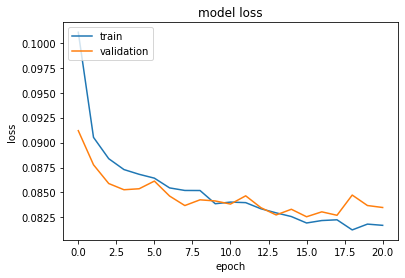

In [25]:
plt.title('Loss')
plt.plot(history['history'].history['loss'])
plt.plot(history['history'].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### ROC curve

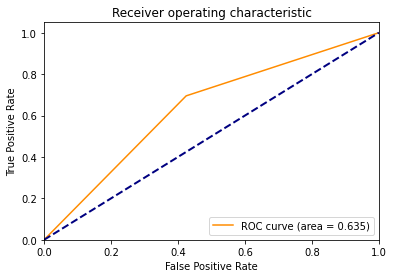

In [26]:
fpr, tpr = history['eval']['roc_cache']
plt.plot(fpr, tpr, color='darkorange', label=f"ROC curve (area = {round(history['eval']['auc'], 3)})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Saving the model

In [27]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

## Assumptions, limitations, conclusion

### Assumptions:
* Main assumption is that stakeholder will prefer to have more false positives (e.g. sending advertisement to people that most likely won't become a customer) than to have false negatives (missing potential customers).
* Therefore, ROC-AUC was selected as a single performance evaluation metric (for ease of comparison between different models).

### Limitations:
Main limitation is lack of proper estimate of Bayess Classifier performance. For instance, for tasks like image classification Bayess Classifier error is usually assumed to be zero, as human performance is around 0% error. However, for task like this it's hard to estimate optimal performance, therefore we can't conclude whether our model is too simple (has removable bias), or we are already performing at best possible rate.  
  
Another limiting factor is small number of samples with 1 target. It may be possible to significantly increase model performance by having more data for class 1.

### Conclusion:
  
Focal loss allows to train model on skewed data without data augumentation or downsampling.  
* $\alpha$ was set to be equal inverse normalized frequency of appearing of this class in data. This can be taken as starting default value that can be tuned later with cross-validation. However, in our case this value appeared to be optimal or close to optimal.  
* $\gamma$ was tuned using validation set.
  
Focal loss gave better performance than using SMOTE to oversample rare class, or than using downsamlping or combinations of above. It also gave better results than simply using weights to account skewed target.  
Setting bias of the final layer to $log(\frac{1 - \pi}{\pi})$, where $\pi$ is normalized frequency of rare class ensure faster convergence and numerical stability. With SMOTEd and downsampled data local optimas of predicting all 0s were a significant problem.  
Tweaking $\gamma$ parameter can lead to either more correctly classified 0 classes, or to more correctly classified 1 classes.

### What else was tried:
* SMOTE, 
* downsampling, 
* ensemble, 
* two stage training (SMOTEd data at stage 1 + downsampled data at stage 2).

## References:

1. https://arxiv.org/pdf/1804.07612.pdf
1. https://www.kaggle.com/abazdyrev/keras-nn-focal-loss-experiments